# GradCAM - Gradient-weighted Class Activation Mapping

## Theoretical Explanation

References:
* https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353
* http://gradcam.cloudcv.org
* https://glassboxmedicine.com/2020/05/29/grad-cam-visual-explanations-from-deep-networks/
* https://github.com/jacobgil/pytorch-grad-cam

It begins with **CAM algorithm:**

A significant drawback of this procedure is that it requires the network to use global average pooling (GAP) as the last step before the prediction layer. It thus is not possible to apply this approach to general CNNs. An example is shown in the figure below:

<img src="https://www.statworx.com/wp-content/uploads/2022/01/Blog_Car-Model-Classification-3_Explainability_CAM_orig_paper-1024x460.jpg" width="600">

The class activation map assigns importance to every position (x, y) in the last convolutional layer by computing the linear combination of the activations, weighted by the corresponding output weights for the observed class (Australian terrier in the example above). The resulting class activation mapping is then upsampled to the size of the input image. This is depicted by the heat map above. Due to the architecture of CNNs, the activation, e.g., in the top left for any layer, is directly related to the top left of the input image. This is why we can conclude which input regions are important by only looking at the last CNN layer.


**Grad CAM algorithm:**

Grad-CAM is a popular technique for visualizing where a convolutional neural network model is looking. Grad-CAM is class-specific, meaning it can produce a separate visualization for every class present in the image:

<img src="https://glassboxmedicine.files.wordpress.com/2020/05/modified-figure-1-dog-cat.png" width="400">

Grad-CAM can be applied to networks with general CNN architectures, containing multiple fully connected layers at the output. It extends the applicability of the CAM procedure by incorporating gradient information. Specifically, the gradient of the loss. The last convolutional layer determines the weight for each of its feature maps. As in the CAM procedure above, the further steps are to compute the weighted sum of the activations and then upsampling the result to the image size to plot the original image with the obtained heatmap.

<img src="https://miro.medium.com/max/720/1*zq1lp5Bg8sdflG_ngrezzg.png" width="900">

While the Grad-CAM paper has been cited several thousand times, recent work demonstrates a serious problem with Grad-CAM: sometimes, Grad-CAM highlights regions of an image that a model did not actually use for prediction. This means Grad-CAM is an unreliable model explanation method. HiResCAM is a new explanation method that is provably guaranteed to highlight only locations the model used. HiResCAM is inspired by Grad-CAM.

Although there are problems on Grad-CAM it is the most used variation of CAM but **there are a lot of variation from the original CAM algorithm:**
* **GradCAM** - Weight the 2D activations by the average gradient
* **HiResCAM** - Like GradCAM but element-wise multiply the activations with the gradients; provably guaranteed faithfulness for certain models
* **GradCAMElementWise** - Like GradCAM but element-wise multiply the activations with the gradients then apply a ReLU operation before summing
* **GradCAM++** - Like GradCAM but uses second order gradients
* **XGradCAM** - Like GradCAM but scale the gradients by the normalized activations
* **AblationCAM** - Zero out activations and measure how the output drops (this repository includes a fast batched implementation)
* **ScoreCAM** - Perbutate the image by the scaled activations and measure how the output drops
* **EigenCAM** - Takes the first principle component of the 2D Activations (no class discrimination, but seems to give great results)
* **EigenGradCAM** - Like EigenCAM but with class discrimination: First principle component of Activations*Grad. Looks like GradCAM, but cleaner
* **LayerCAM** - Spatially weight the activations by positive gradients. Works better especially in lower layers
* **FullGrad** - Computes the gradients of the biases from all over the network, and then sums them

## Tensorflow General configs and imports

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import pandas as pd 
import numpy as np
import seaborn as sns
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Imports

In [2]:
import numpy as np
import tensorflow as tf
import pathlib
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image

## Data pre-processing

In [3]:
# Obtain and prepare dataset

data_dir = pathlib.Path('../input/monkeypoxdataset/MonkeypoxSkinDataset')

# Input size Final
batch_size = 32
IMG_SIZE = (124,124)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

class_names = train_ds.class_names

Found 42350 files belonging to 6 classes.
Using 33880 files for training.
Found 42350 files belonging to 6 classes.
Using 8470 files for validation.


In [4]:
train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)

val_batches = val_ds.cardinality().numpy()
test_ds = val_ds.take(val_batches // 3) 
val_ds = val_ds.skip(val_batches // 3)

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Transfer Learning on Xception model

In [5]:
# create the base pre-trained model
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# and a logistic layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

83697664/83683744 [==============================] - 1s 0us/step


In [6]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# this is the model we will train
xception_model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
xception_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [9]:
# Load model if already trained
# Ignore warning "Could not open.." - it will work even with that message

xception_model.load_weights('../input/xceptionmodeltf/xceptionmodeltfv2')

In [10]:
# Even if you load an already trained model in cell above you need to compile it as well

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

xception_model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [11]:
# Training (will take time if no GPU or TPU is being used - even with GPU/TPU it takes a while)
# Dont run it if you already load the weights

history = xception_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 10,
)

Epoch 1/10
1059/1059 [==============================] - 125s 110ms/step - loss: 0.3508 - accuracy: 0.8814 - val_loss: 0.4083 - val_accuracy: 0.8536
Epoch 2/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.3374 - accuracy: 0.8853 - val_loss: 0.3961 - val_accuracy: 0.8566
Epoch 3/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.3222 - accuracy: 0.8903 - val_loss: 0.3858 - val_accuracy: 0.8590
Epoch 4/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.3091 - accuracy: 0.8945 - val_loss: 0.3776 - val_accuracy: 0.8624
Epoch 5/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2981 - accuracy: 0.8983 - val_loss: 0.3711 - val_accuracy: 0.8636
Epoch 6/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2886 - accuracy: 0.9016 - val_loss: 0.3658 - val_accuracy: 0.8677
Epoch 7/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2804 - accuracy: 0.9043 - val_loss: 0.3615

<AxesSubplot:>

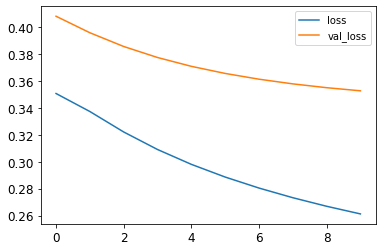

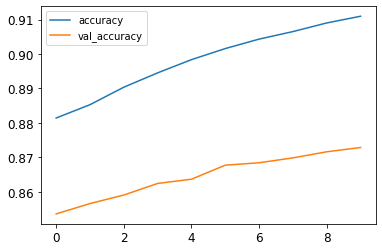

In [12]:
# Results visualization
# Loss and validation loss variation 

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [13]:
#Save the previous trained model

modelSaving = xception_model.save_weights('./xceptionmodel', save_format='h5')

In [14]:
#test sample evaluation

score = xception_model.evaluate(test_ds)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

88/88 [==============================] - 3s 30ms/step - loss: 0.3263 - accuracy: 0.8835
Test loss:  0.3263017535209656
Test accuracy:  0.8835227489471436


## GradCam implementation

794624/785294 [==============================] - 0s 0us/step


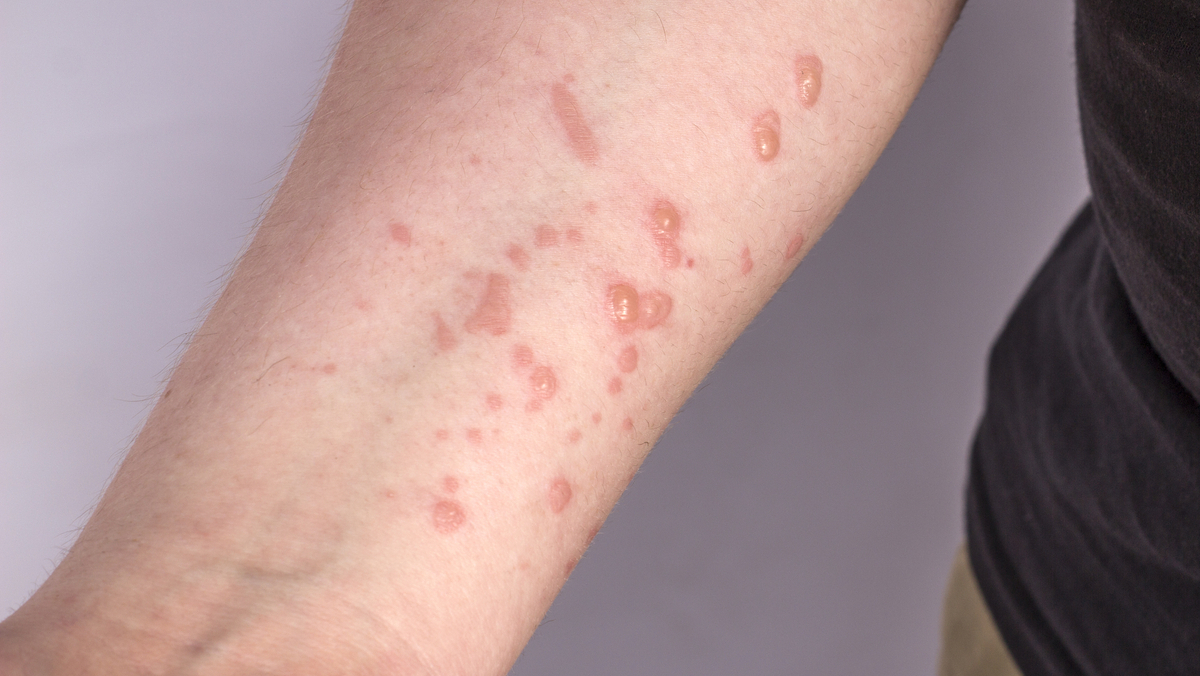

In [15]:
img_size = (124, 124)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

#Last conv layer activation
last_conv_layer_name = "block14_sepconv2_act"

# The path to the target image
img_path = keras.utils.get_file(
    "monkeypox9_img.jpg", "https://portaldrauziovarella.nyc3.digitaloceanspaces.com/wp-content/uploads/2022/07/25141417/Depositphotos_481360378_L-1-2.jpg"
)

display(Image(img_path))

In [16]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Predicted: smallpox


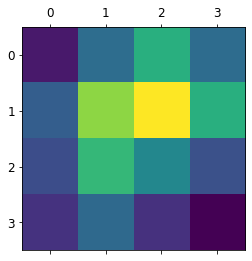

In [17]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Remove last layer's softmax
xception_model.layers[-1].activation = None

# Print what the top predicted class is
preds = xception_model.predict(img_array)
label_pos = preds.argmax(axis=1)[0]
print("Predicted:", class_names[label_pos])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, xception_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

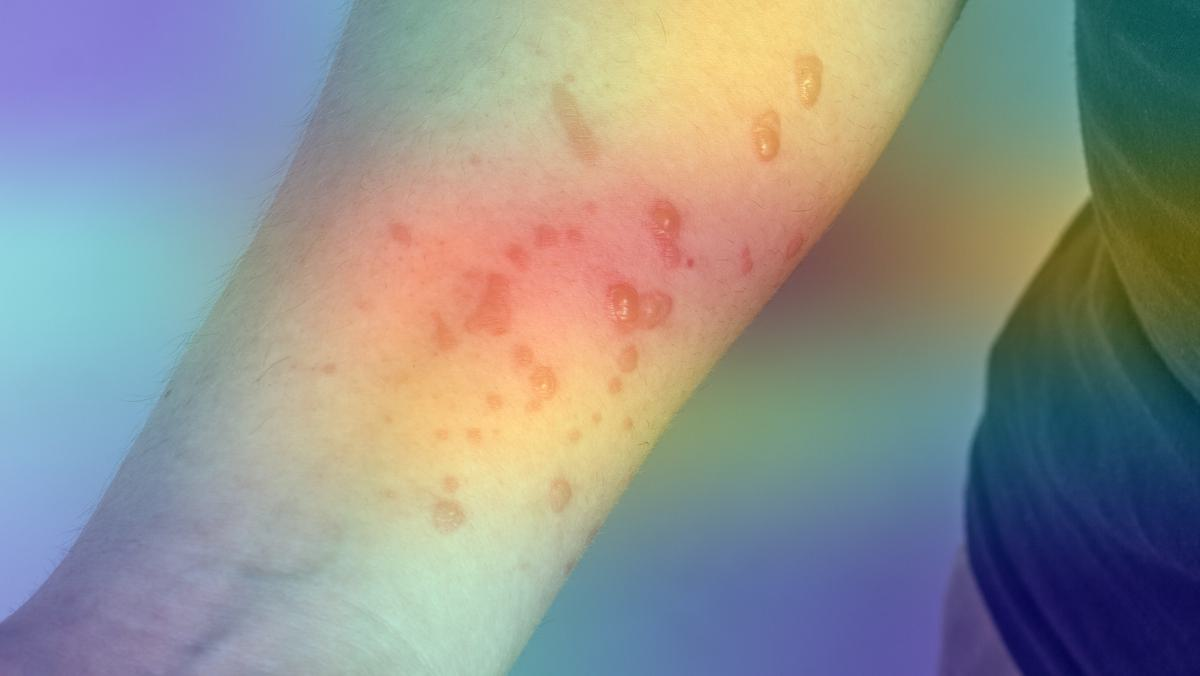

In [18]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)